In [1]:
import os
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
import torch
import tqdm
import platform
import shutil
import json
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt

/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Michelle
data_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/"
model_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/models/"
if platform.node() == 'navi': # Daniel
    data_prefix = "/home/argon/Stuff/CSE244A_project/"
    model_prefix = "/home/argon/Stuff/CSE244A_project/models/"

In [3]:
categories = pd.read_csv(os.path.join(data_prefix, 'categories.csv'))
train_labels = pd.read_csv(os.path.join(data_prefix, 'train_labeled.csv'))

In [4]:
def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler=None):
    checkpoint_dict = {
        "epoch": epoch,
        "model_dict": model.state_dict(),
        "optimizer_dict": optimizer.state_dict(),
    }
    
    # Consistently name the scheduler key as "scheduler_dict"
    if scheduler:
        checkpoint_dict["scheduler_dict"] = scheduler.state_dict()

    torch.save(checkpoint_dict, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_dict"])
    
    # Consistently access the scheduler as "scheduler_dict"
    if scheduler and "scheduler_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_dict"])
        
    return checkpoint["epoch"]

class TrainingHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def save(self, history_path):
        with open(history_path, "w", encoding="utf-8") as f:
            json.dump({
                "train_loss": self.train_loss,
                "val_loss": self.val_loss,
                "train_acc": self.train_acc,
                "val_acc": self.val_acc,
            }, f)

    def load(self, history_path):
        with open(history_path, "r", encoding="utf-8") as f:
            hist = json.load(f)
        self.train_loss = hist["train_loss"]
        self.val_loss = hist["val_loss"]
        self.train_acc = hist["train_acc"]
        self.val_acc = hist["val_acc"]

    def append(self, train_loss, val_loss, train_acc, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

    def is_best(self):
        """Return true if the last epoch added is the best seen so far"""
        return all([self.val_loss[-1] < i for i in self.val_loss[:-1]])

In [5]:
# Define a dataset class for labeled images
class LabeledImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.data.iloc[idx, 1]  # Assuming the label is in the second column

        if self.transform:
            image = self.transform(image)

        return image, label

# Define a dataset class for unlabeled images
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image  # No label returned

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std as needed
])

In [7]:
# Initialize datasets
labeled_dataset = LabeledImageDataset(csv_file=os.path.join(data_prefix,'train_labeled.csv'), root_dir=os.path.join(data_prefix,'train/labeled'), transform=transform)
unlabeled_dataset = UnlabeledImageDataset(root_dir=os.path.join(data_prefix,'train/unlabeled'), transform=transform)

# Training / validation split
val_ratio = 0.1
batch_size = 16

val_size = int(val_ratio * len(labeled_dataset))
train_size = len(labeled_dataset) - val_size

generator1 = torch.Generator().manual_seed(12341234)
# Generate as indices so we can save them if needed, but I'm not doing that yet - Daniel
val_idx, train_idx = torch.utils.data.random_split(torch.arange(len(labeled_dataset)), [val_size, train_size], generator=generator1)
train =  torch.utils.data.Subset(labeled_dataset, train_idx)
val =  torch.utils.data.Subset(labeled_dataset, val_idx)

labeled_train_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
labeled_val_data = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)


Labeled images:


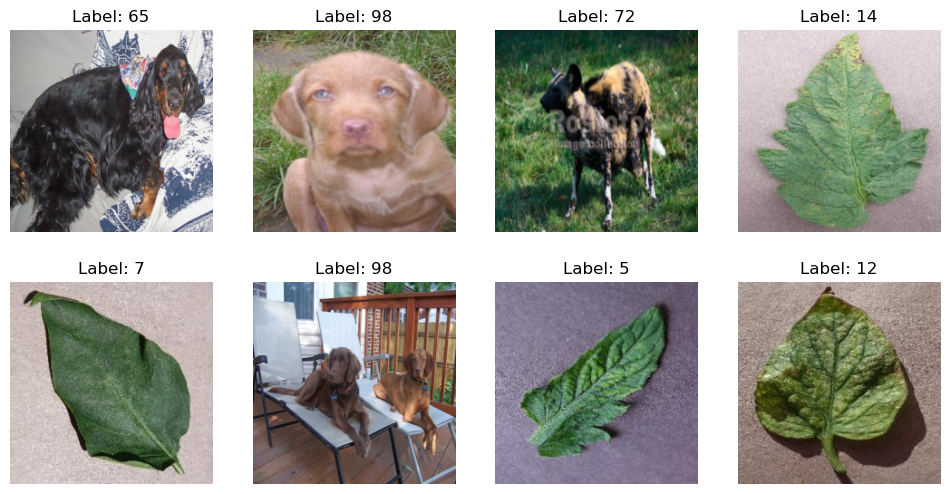

In [8]:
# Function to display a batch of labeled images with labels
def show_labeled_batch(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = img/2 + 0.5 # This roughly un-normalizes them back to a valid range for imshow - Daniel
        plt.imshow(img)
        plt.title(f'Label: {labels[idx].item()}')
        plt.axis('off')
    plt.show()

# Function to display a batch of unlabeled images
def show_unlabeled_batch(data_loader):
    images = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = img/2 + 0.5 # This roughly un-normalizes them back to a valid range for imshow - Daniel
        plt.imshow(img)
        plt.title("Unlabeled Image")
        plt.axis('off')
    plt.show()

# Display a batch of labeled images
print("Labeled images:")
show_labeled_batch(labeled_train_data)
pass

# # Display a batch of unlabeled images
# print("Unlabeled images:")
# show_unlabeled_batch(unlabeled_loader)


In [9]:
# Someday this should probably be some yaml files... - Daniel

#TODO: Add batch size to this
#TODO: Add model type (e.g. facebookresearch/deit:main)

# training_config = {
#     "model_name":  "michelle_diet__steplr_3_0.97",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0,
#     "scheduler_type": "StepLR",
#     "scheduler_params": {"step_size": 3,
#                          "gamma": 0.97},
# }

# training_config = {
#     "model_name":  "michelle_diet__plateaulr_0.1_0_0.0",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0,
#     "scheduler_type": "ReduceLROnPlateau",
#     "scheduler_params": {"factor": 0.1,
#                          "patience": 0,
#                          "threshold": 0.0},
# }

# training_config = {
#     "model_name":  "michelle_diet__freeze11__plateaulr_0.1_0_0.0__wdecay_1en4",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "scheduler_type": "ReduceLROnPlateau",
#     "scheduler_params": {"factor": 0.1,
#                          "patience": 0,
#                          "threshold": 0.0},
#     "unfreeze_layers": ['blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }

training_config = {
    "model_name":  "michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4",
    "optimizer_type": "AdamW",
    "optimizer_lr": 0.0001,
    "optimizer_wd": 0.0001,
    "scheduler_type": "ReduceLROnPlateau",
    "scheduler_params": {"factor": 0.1,
                         "patience": 0,
                         "threshold": 0.0},
    "unfreeze_layers": ['blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
}

In [10]:
# https://pytorch.org/tutorials/beginner/vt_tutorial.html
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cache found in /home/argon/.cache/torch/hub/facebookresearch_deit_main
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/argon/.cache/torch/hub/facebookresearch_deit_main/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @regis

In [11]:
# Modify the final layer to match the number of classes
num_classes = len(categories)  # Adjust to the actual number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

In [12]:
# https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to(device)
if not "optimizer_type" in training_config or training_config["optimizer_type"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
elif training_config["optimizer_type"] == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
else:
    raise NotImplementedError()
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)


In [ ]:
def freeze_by_list(model, unfrozen):
    # https://stackoverflow.com/questions/62523912/freeze-certain-layers-of-an-existing-model-in-pytorch
    total_unfrozen = 0
    for name, param in model.named_parameters():
        if name in unfrozen:
            total_unfrozen += 1
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

if "unfreeze_layers" in training_config:
    freeze_by_list(model, training_config["unfreeze_layers"])

[(i[0], i[1].requires_grad) for i in model.named_parameters()]

[('cls_token', False),
 ('pos_embed', False),
 ('patch_embed.proj.weight', False),
 ('patch_embed.proj.bias', False),
 ('blocks.0.norm1.weight', False),
 ('blocks.0.norm1.bias', False),
 ('blocks.0.attn.qkv.weight', False),
 ('blocks.0.attn.qkv.bias', False),
 ('blocks.0.attn.proj.weight', False),
 ('blocks.0.attn.proj.bias', False),
 ('blocks.0.norm2.weight', False),
 ('blocks.0.norm2.bias', False),
 ('blocks.0.mlp.fc1.weight', False),
 ('blocks.0.mlp.fc1.bias', False),
 ('blocks.0.mlp.fc2.weight', False),
 ('blocks.0.mlp.fc2.bias', False),
 ('blocks.1.norm1.weight', False),
 ('blocks.1.norm1.bias', False),
 ('blocks.1.attn.qkv.weight', False),
 ('blocks.1.attn.qkv.bias', False),
 ('blocks.1.attn.proj.weight', False),
 ('blocks.1.attn.proj.bias', False),
 ('blocks.1.norm2.weight', False),
 ('blocks.1.norm2.bias', False),
 ('blocks.1.mlp.fc1.weight', False),
 ('blocks.1.mlp.fc1.bias', False),
 ('blocks.1.mlp.fc2.weight', False),
 ('blocks.1.mlp.fc2.bias', False),
 ('blocks.2.norm1.weig

In [14]:
# lr scheduler
if "scheduler_type" in training_config:
    if training_config["scheduler_type"] == "StepLR":
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **training_config["scheduler_params"])
else:
    lr_scheduler = None
print(lr_scheduler)

In [15]:
model_path = os.path.join(model_prefix, training_config["model_name"])
os.makedirs(model_path, exist_ok=True)

In [16]:
num_epochs = 15  # Adjust as needed

In [17]:
model.to(device)
start_epoch = 0
hist = TrainingHistory()

checkpoint_path = os.path.join(model_path, "checkpoint.pth")
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, lr_scheduler, device=device)
    hist.load(os.path.join(model_path, "history.json"))

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for images, labels in tqdm.tqdm(labeled_train_data, desc=f"Train ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

        
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for images, labels in tqdm.tqdm(labeled_val_data, desc=f"Validation ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track statistics
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()
    
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler.step(val_loss)
    elif lr_scheduler:
        lr_scheduler.step()
    
    tmp_checkpoint_path = os.path.join(model_path, f"checkpoint-{epoch}.pth")
    save_checkpoint(tmp_checkpoint_path, epoch + 1, model, optimizer, lr_scheduler)
    shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"checkpoint.pth"))
    if hist.is_best():
        shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"checkpoint-best.pth"))
    os.unlink(tmp_checkpoint_path)

    hist.append(train_loss/train_total, val_loss/val_total, train_correct/train_total, val_correct/val_total)
    hist.save(os.path.join(model_path, "history.json"))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/train_total:.6f}, Val Loss: {val_loss/val_total:.6f}")
    print(f"      Train Accuracy: {100 * train_correct/train_total:.2f}%, Val Accuracy: {100 * val_correct/val_total:.2f}%")
    print(f"      New LR={[g['lr'] for g in optimizer.param_groups]}")


Validation (1/15): 100%|██████████| 62/62 [00:02<00:00, 28.27it/s]


Epoch [1/15], Train Loss: 0.113864, Val Loss: 0.069858
      Train Accuracy: 76.55%, Val Accuracy: 90.76%
      New LR=[0.0001]


Validation (2/15): 100%|██████████| 62/62 [00:02<00:00, 29.49it/s]


Epoch [2/15], Train Loss: 0.060840, Val Loss: 0.066116
      Train Accuracy: 96.40%, Val Accuracy: 92.99%
      New LR=[0.0001]


Validation (3/15): 100%|██████████| 62/62 [00:02<00:00, 29.72it/s]


Epoch [3/15], Train Loss: 0.056012, Val Loss: 0.064755
      Train Accuracy: 98.85%, Val Accuracy: 94.42%
      New LR=[0.0001]


Validation (4/15): 100%|██████████| 62/62 [00:02<00:00, 29.68it/s]


Epoch [4/15], Train Loss: 0.054002, Val Loss: 0.064940
      Train Accuracy: 99.47%, Val Accuracy: 94.52%
      New LR=[1e-05]


Validation (5/15): 100%|██████████| 62/62 [00:02<00:00, 29.99it/s]


Epoch [5/15], Train Loss: 0.052811, Val Loss: 0.064299
      Train Accuracy: 99.89%, Val Accuracy: 94.82%
      New LR=[1e-05]


Validation (6/15): 100%|██████████| 62/62 [00:02<00:00, 29.92it/s]


Epoch [6/15], Train Loss: 0.052540, Val Loss: 0.064359
      Train Accuracy: 99.91%, Val Accuracy: 94.82%
      New LR=[1.0000000000000002e-06]


Validation (7/15): 100%|██████████| 62/62 [00:02<00:00, 29.91it/s]


Epoch [7/15], Train Loss: 0.052419, Val Loss: 0.064398
      Train Accuracy: 99.93%, Val Accuracy: 94.82%
      New LR=[1.0000000000000002e-07]


Train (8/15):   4%|▎         | 20/555 [00:00<00:21, 24.88it/s]


KeyboardInterrupt: 

In [ ]:
# Plot Loss
plt.plot(range(len(hist.train_loss)), hist.train_loss, label="Train")
plt.plot(range(len(hist.val_loss)), hist.val_loss, label="Validation")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
# Plot Accuracy
plt.plot(range(len(hist.train_acc)), hist.train_acc, label="Train")
plt.plot(range(len(hist.val_acc)), hist.val_acc, label="Validation")
plt.legend()
plt.ylabel("% Accuracy")
plt.xlabel("Epoch")